In [6]:
import os
import regex
from pathlib import Path
import pandas as pd
import numpy as np

In [16]:
model_deployment_name = "llama-3-70b-chat"
# gen_objective_tag = "Y02E_electrical_components"
# llm_tags = ["llama", "mistral", "mistral-8x7b", "dbrx", "qwen"]
# labels = ["llama-3-70b", "mistral-7b", "mistral-8x7b", "dbrx-130b", "qwen-70b"]

# gen_objective_tag = "transport_innovation"
gen_objective_tag = "Y02E_electrical_components"
llm_tags = ["mistral", "llama", "qwen", "dbrx"]
labels = ["mistral-7b", "llama-3-70b", "qwen-72b", "dbrx-132b"]

topicgpt_path = Path("../../topicGPT")
output_path = topicgpt_path / "data" / "output" / model_deployment_name / gen_objective_tag
topic_path = output_path / "generation_1.md"
fig_path = Path(f"../reports/figures/")
# tags_labels = np.stack((llm_tags, labels), axis=1)
# tags_labels = tags_labels[[1, 2, 4, 0, 3]].T
# llm_tags = tags_labels[0]
# labels = tags_labels[1]

In [17]:
topic_format = regex.compile("(^\[\d+\] [\w\s]+):")


def extract_topics_from_cell(response: str):
    topics = []
    for line in map(str.strip, response.strip().split("\n")):
        matches = regex.findall(topic_format, line)
        none_matches = line.lower().count("none")
        if (len(matches) == 0) and (none_matches == 0):
            continue
        elif len(matches) == 1:
            topic = matches[0]
            topics.append(topic)
        elif len(matches) > 1:
            raise AssertionError("There should not be multiple topics in one line!")
        else:
            topics.append("none")
            print("None assigned!")

    return topics


def extract_topics(responses_1: pd.Series, responses_2: pd.Series, llm_tag_1, llm_tag_2):
    topics = []
    topics.append(responses_1.apply(extract_topics_from_cell))
    topics.append(responses_2.apply(extract_topics_from_cell))

    topics = pd.DataFrame(topics).T
    topics.columns = [llm_tag_1, llm_tag_2]
    return topics


def filter_hallucinated_topics(topics: pd.DataFrame, real_topics: set):
    topics = topics.map(lambda labels: real_topics.intersection(labels))
    return topics


def read_topic_file(topic_file):
    topics = []
    with open(topic_file, "r") as file:
        for line in file:
            topic = line.split("(")[0].strip()
            topics.append(topic)
    return set(topics)

In [18]:
def compute_pairwise_metrics(llm_tag_1, llm_tag_2, real_topics: set):
    real_topics = set(map(str.lower, real_topics))

    assignment_path_llm_1 = output_path / f"assignment_{llm_tag_1}.jsonl"
    assignment_path_llm_2 = output_path / f"assignment_{llm_tag_2}.jsonl"
    assignment_1 = pd.read_json(assignment_path_llm_1, lines=True)
    assignment_2 = pd.read_json(assignment_path_llm_2, lines=True)

    topics_raw = extract_topics(assignment_1.responses, assignment_2.responses, llm_tag_1, llm_tag_2)
    topics_raw = topics_raw.map(lambda s: set(map(str.lower, s)))

    topics_count_1_raw = topics_raw[llm_tag_1].apply(len)
    topics_count_2_raw = topics_raw[llm_tag_2].apply(len)

    topics = filter_hallucinated_topics(topics_raw, real_topics)

    n = len(topics)
    topics_count_1 = topics[llm_tag_1].apply(len)
    topics_count_2 = topics[llm_tag_2].apply(len)

    hallucination_rate_1 = (topics_count_1_raw - topics_count_1).sum() / topics_count_1_raw.sum()
    hallucination_rate_2 = (topics_count_2_raw - topics_count_2).sum() / topics_count_2_raw.sum()
    print(f"Share of hallucinated topics: {llm_tag_1}={hallucination_rate_1:.2%}, {llm_tag_2}={hallucination_rate_2:.2%}")

    topics_expanded = topics.explode(llm_tag_1).explode(llm_tag_2)

    # Compute pairwise metrics
    n_1_raw, n_2_raw = sum(topics_count_1_raw) / n, sum(topics_count_2_raw) / n
    n_1, n_2 = sum(topics_count_1) / n, sum(topics_count_2) / n

    agreement = topics_expanded[llm_tag_1] == topics_expanded[llm_tag_2]
    agreement.name = "overlap"

    jaccard = topics[(topics_count_1 + topics_count_2) != 0].apply(
        lambda row:
            len(set(row.loc[llm_tag_1]).intersection(row.loc[llm_tag_2])) /
            len(set(row.loc[llm_tag_1]).union(row.loc[llm_tag_2])), axis=1
    )
    jaccard[jaccard.isna()] = 0

    agreement = agreement.groupby(agreement.index).aggregate(["mean", "count"])
    overlap_left = (agreement.prod(axis=1) / topics_count_1)
    overlap_right = (agreement.prod(axis=1) / topics_count_2)
    overlap_coef = (agreement.prod(axis=1) / np.minimum(topics_count_1, topics_count_2))
    overlap_left[overlap_left.isna()] = 0
    overlap_right[overlap_right.isna()] = 0
    overlap_coef[overlap_coef.isna()] = 0

    any_match = (agreement["mean"] > 0).astype(int)
    exact_match = (agreement["mean"] == 1).astype(int)

    # Assign scores of 1 when both label sets are empty and none was predicted
    empty_mask = (topics_count_1 + topics_count_2) == 0
    none_assignments = topics_raw.map(lambda s: "none" in s).all(axis=1)
    print(topics_raw.map(lambda s: "none" in s).sum(axis=0))
    default_mask = empty_mask & none_assignments

    jaccard[default_mask] = 1
    overlap_coef[default_mask] = 1
    any_match[default_mask] = 1
    exact_match[default_mask] = 1

    any_match = any_match.mean()
    exact_match = exact_match.mean()

    mean_jaccard = jaccard.mean()
    mean_overlap_coef = overlap_coef.mean()
    mean_match_left = overlap_left.mean()
    mean_match_right = overlap_right.mean()

    llm_stats = {llm_tag_1: [hallucination_rate_1, n_1_raw, n_1],
                 llm_tag_2: [hallucination_rate_2, n_2_raw, n_2]}

    metrics = {"Jaccard Coefficient": mean_jaccard,
               "Overlap Coefficient": mean_overlap_coef,
               "Any Match": any_match,
               "Exact Match": exact_match}

    print(f"Avg #topics: {llm_tag_1}: {n_1}, {llm_tag_2}: {n_2}")
    print(f"Mean overlap {llm_tag_1}: {mean_match_left:.2%}")
    print(f"Mean overlap {llm_tag_2}: {mean_match_right:.2%}")
    print(f"Mean single-match overlap: {any_match:.2%}")
    print(f"Jaccard: {mean_jaccard:.4f}")
    print()

    # return (overlap_left.mean() + overlap_right.mean()) / 2
    # return (overlap > 0).mean()
    return metrics, llm_stats

In [19]:
real_topics = read_topic_file(topic_path)
n = len(llm_tags)
template = np.full((n, n), fill_value=np.nan)
metrics_dict = {"Jaccard Coefficient": template.copy(),
                "Overlap Coefficient": template.copy(),
                "Any Match": template.copy(),
                "Exact Match": template.copy()}
llm_stats_dict = {}

for i in range(n):
    for j in range(i+1, n):
        metrics, llm_stats = compute_pairwise_metrics(llm_tags[i], llm_tags[j], real_topics)
        for key, val in metrics.items():
            metrics_dict[key][i, j] = val
        llm_stats_dict.update(llm_stats)

None assigned!
None assigned!
None assigned!
None assigned!
None assigned!
None assigned!
None assigned!
None assigned!
None assigned!
Share of hallucinated topics: mistral=30.33%, llama=13.57%
mistral    2
llama      7
dtype: int64
Avg #topics: mistral: 1.7, llama: 1.72
Mean overlap mistral: 39.30%
Mean overlap llama: 38.28%
Mean single-match overlap: 52.00%
Jaccard: 0.3331

None assigned!
None assigned!
None assigned!
None assigned!
None assigned!
None assigned!
Share of hallucinated topics: mistral=30.33%, qwen=13.85%
mistral    2
qwen       4
dtype: int64
Avg #topics: mistral: 1.7, qwen: 2.55
Mean overlap mistral: 44.58%
Mean overlap qwen: 33.38%
Mean single-match overlap: 58.00%
Jaccard: 0.2979

None assigned!
None assigned!
Share of hallucinated topics: mistral=30.33%, dbrx=22.09%
mistral    2
dbrx       0
dtype: int64
Avg #topics: mistral: 1.7, dbrx: 2.68
Mean overlap mistral: 47.23%
Mean overlap dbrx: 30.25%
Mean single-match overlap: 61.00%
Jaccard: 0.2691

None assigned!
None

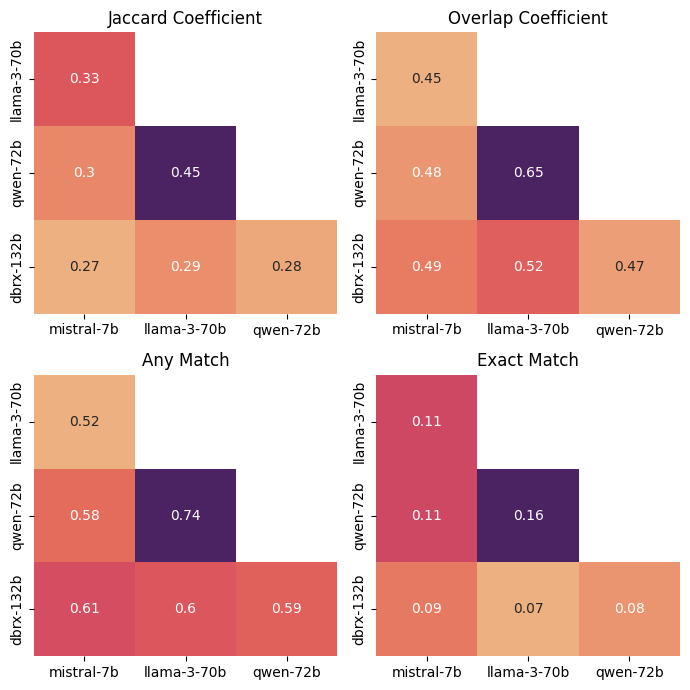

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# diag_idxs = np.repeat(np.arange(n)[:, np.newaxis], axis=1, repeats=2).T
# diag = np.zeros((n, n))
# diag[diag_idxs[0], diag_idxs[1]] = np.nan

fig, axes = plt.subplots(2, len(metrics_dict)//2)
fig.set_size_inches(7, 7)
for (label, mat), ax in zip(metrics_dict.items(), np.array(axes).flat):
    # metrics_full = metrics + metrics.T + diag
    mat_formatted = mat.copy().T[1:, :-1]
    # mat_formatted[np.isnan(mat_formatted)] = 0
    # mat_formatted = mat_formatted + mat_formatted.T
    mat_formatted[mat_formatted == 0] = np.nan
    sns.heatmap(mat_formatted, annot=mat_formatted, xticklabels=labels[:-1], yticklabels=labels[1:], cmap="flare", ax=ax, cbar=False)
    # ax.set_xticklabels(45, rotation=45)
    ax.set_title(label)
fig.tight_layout()
fig.savefig(fig_path / f"agreement_metrics-{gen_objective_tag}.svg",
            bbox_inches="tight")

In [64]:
llm_stats_labels = ["Hallucination Rate", "\#Topics (raw)", "\#Topics (clean)"]
llm_stats = pd.DataFrame(llm_stats_dict).T
llm_stats.index = labels
llm_stats.columns = llm_stats_labels
llm_stats["Hallucination Rate"] = llm_stats["Hallucination Rate"].map(lambda r: f"{r:.2%}".replace("%", "\%"))
llm_stats = llm_stats.round(2).map(str)

table = llm_stats.T.to_latex()
with open(f"../reports/llm_stats_{gen_objective_tag}_table.tex", "w") as file:
    file.write(table)
    file.close()